In [132]:
import os
import tensorflow as tf 
import tensorflow_io as tfio
import librosa
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [133]:
Yes_Boat = os.path.join('Y_N_Boat', 'y', 'y_1_cargo')
No_Boat = os.path.join('Y_N_Boat', 'n', 'n_CCC_124.20220627_055000')

In [134]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    sample_rate
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav


In [135]:
def augment_spectrogram(spectrogram, label):
    # Randomly choose the type of augmentation
    choice = tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32)
    
    if choice == 0:
        # Apply random brightness
        spectrogram = tf.image.random_brightness(spectrogram, max_delta=0.05)
    elif choice == 1:
        # Apply frequency masking
        # Ensure that the frequency mask doesn't change the overall shape of the spectrogram
        spectrogram = tfio.audio.freq_mask(spectrogram, param=30)
    elif choice == 2:
        # Apply time masking
        # Ensure that the time mask doesn't change the overall shape of the spectrogram
        spectrogram = tfio.audio.time_mask(spectrogram, param=30)

    return spectrogram, label

In [136]:
POS = os.path.join('Y_N_Boat', 'y')
NEG = os.path.join('Y_N_Boat', 'n')

In [137]:
num_files = len(os.listdir(NEG))    
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav').take(num_files)

In [138]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [145]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    choice = tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32)
    if choice == 0:
        # Data Augmentation
        spectrogram, label = augment_spectrogram(spectrogram, label)
    
    # Normalization
    # Mean and standard deviation for normalization
    mean = tf.math.reduce_mean(spectrogram)
    std = tf.math.reduce_std(spectrogram)
    
    # Normalize the spectrogram
    spectrogram = (spectrogram - mean) / std

    spectrogram = tf.image.random_brightness(spectrogram, max_delta=0.05)
    
    
    
    return spectrogram, label


In [153]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
filepath

b'Y_N_Boat\\y\\y_CCC_123.20220630_233600.wav'

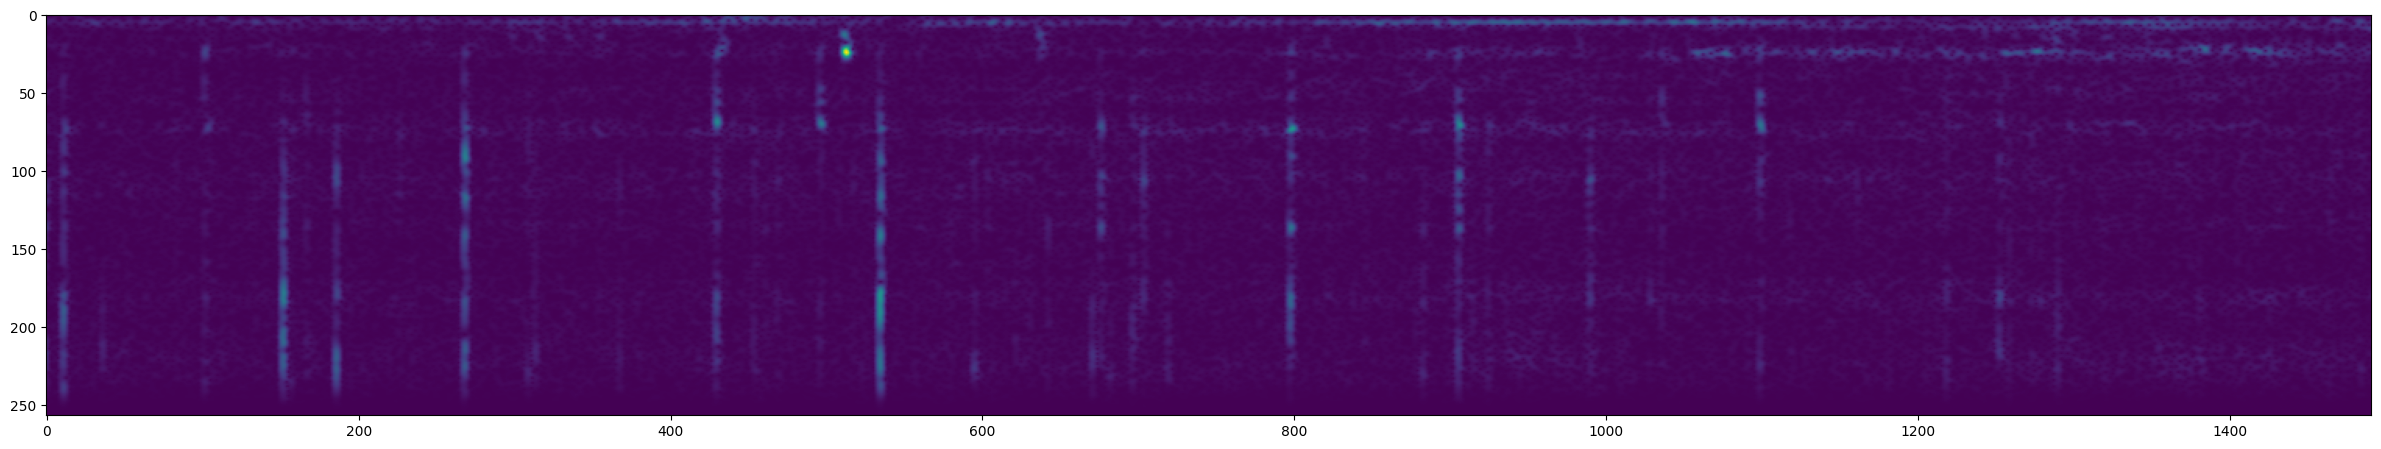

In [154]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()
